In [185]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [186]:
import pickle
import glob
import itertools
from typing import List, Callable

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.settings.tier import Tier
from src.settings.strategy import Strategy

from src.utils.utils import get_generator, get_project_root, make_path_if_not_exists, load_model

In [187]:
MODE = 'talk'
FIGSIZE = (0, 0)
DPI = 0

# Paper dimensions

# Presentation dimensions
LABEL_SIZE_TALK = 16
DPI_TALK = 96
FIGSIZE_TALK = (13.33, 7.5)
FONTSIZE_TALK = 18

In [188]:
def get_lime_df(tier: Tier, strategy: Strategy):
    paths = get_explanation_paths("lime", tier, strategy)
    df = pd.concat([pd.read_json(path) for path in paths])
    return df

def get_shap_df(tier: Tier, strategy: Strategy):
    paths = get_explanation_paths("shap", tier, strategy)

    pickled_explanations = {}

    for path in paths:
        with open(path, mode='rb') as shap_explanation:
            clean_path = path.replace(f"/home/tvangraft/tudelft/thesis/metaengineering/explanation/{tier}/shap/{strategy}_", "").replace(".pickle", "")
            pickled_explanations[clean_path] = pickle.load(shap_explanation)

    return pickled_explanations

def get_explanation_paths(type: str, tier: Tier, strategy: Strategy):
    explanation_path = f"/home/tvangraft/tudelft/thesis/metaengineering/explanation/{tier}/{type}"
    paths = glob.glob(f"{explanation_path}/{strategy}_*")
    return paths

def set_context(mode):
    if mode == 'talk':
        sns.set_context(
            "talk",
            rc={
                "font_size": FONTSIZE_TALK,
                "axes.labelsize": LABEL_SIZE_TALK,
            }
        )
        fig = plt.figure(figsize=FIGSIZE_TALK, dpi=DPI_TALK)
        return fig

def save_fig(path: str, name: str):
    make_path_if_not_exists(path)
    plt.savefig(f"{path}/{name}.png", bbox_inches='tight')
    plt.savefig(f"{path}/{name}.svg", bbox_inches='tight')
    
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)
shap_explanations = get_shap_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)

In [189]:
def count_overlap(enzymes_one: List, enzymes_two: List):
    idx = 20
    return len(set(enzymes_one[:idx]) & set(enzymes_two[:idx])) / len(enzymes_one[:idx])

def kendalltau(enzymes_one: List, enzymes_two: List):
    from scipy.stats import kendalltau
    return kendalltau(enzymes_one, enzymes_two)[0]

def rank_correlation_metabolite_id(df: pd.DataFrame, metabolite_id: str, agg_func):
    _df = df[df['metabolite_id'] == metabolite_id].set_index('KO_ORF')
    return rank_correlation(_df, agg_func)

def rank_correlation_knockout(df: pd.DataFrame, knockout_id: str, agg_func):
    _df = df[df['KO_ORF'] == knockout_id].set_index('metabolite_id')
    return rank_correlation(_df, agg_func)

def rank_correlation_all(df: pd.DataFrame, agg_func: Callable):
    _df = df.reset_index()
    return rank_correlation(_df, agg_func)

def rank_correlation(_df: pd.DataFrame, agg_func: Callable):
    unique_knockouts = _df.index.to_list()
    knockout_combinations = list(itertools.combinations(unique_knockouts, r=2))
    
    n = len(unique_knockouts)
    r = np.ones((n, n))
    triu = np.triu_indices(n, 1)
    tril = np.tril_indices(n, -1)
    
    key = 'exp_enzymes'
    kendalltau_correllation = [agg_func(_df.loc[left_knockout][key], _df.loc[right_knockout][key]) for (left_knockout, right_knockout) in knockout_combinations]
    
    r[triu] = kendalltau_correllation
    r[tril] = r.T[tril]
    
    return r, unique_knockouts



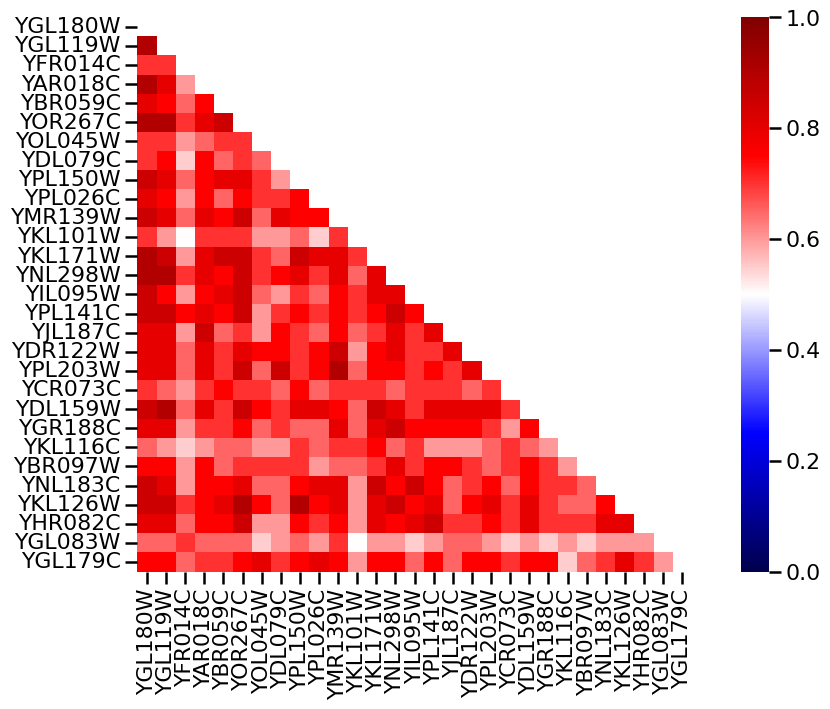

In [190]:
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.ALL)
figure = set_context(MODE)
ax = figure.add_subplot(1, 1, 1)
unique_metabolite_id = 'pep'
correlation_matrix, knockouts = rank_correlation_metabolite_id(df, unique_metabolite_id, count_overlap)
sns.heatmap(
    correlation_matrix, 
    square=True, 
    # annot=True,
    # fmt=".2f",
    vmax=1,
    vmin=0,
    ax=ax,
    xticklabels=knockouts,
    yticklabels=knockouts,
    cmap="seismic",
    mask=np.triu(correlation_matrix),
    # cbar=False,
)
plt.savefig(f"./{unique_metabolite_id}.png")
save_fig(path=f'./images/{MODE}/explanation/', name="pyruvate_count_overlap")

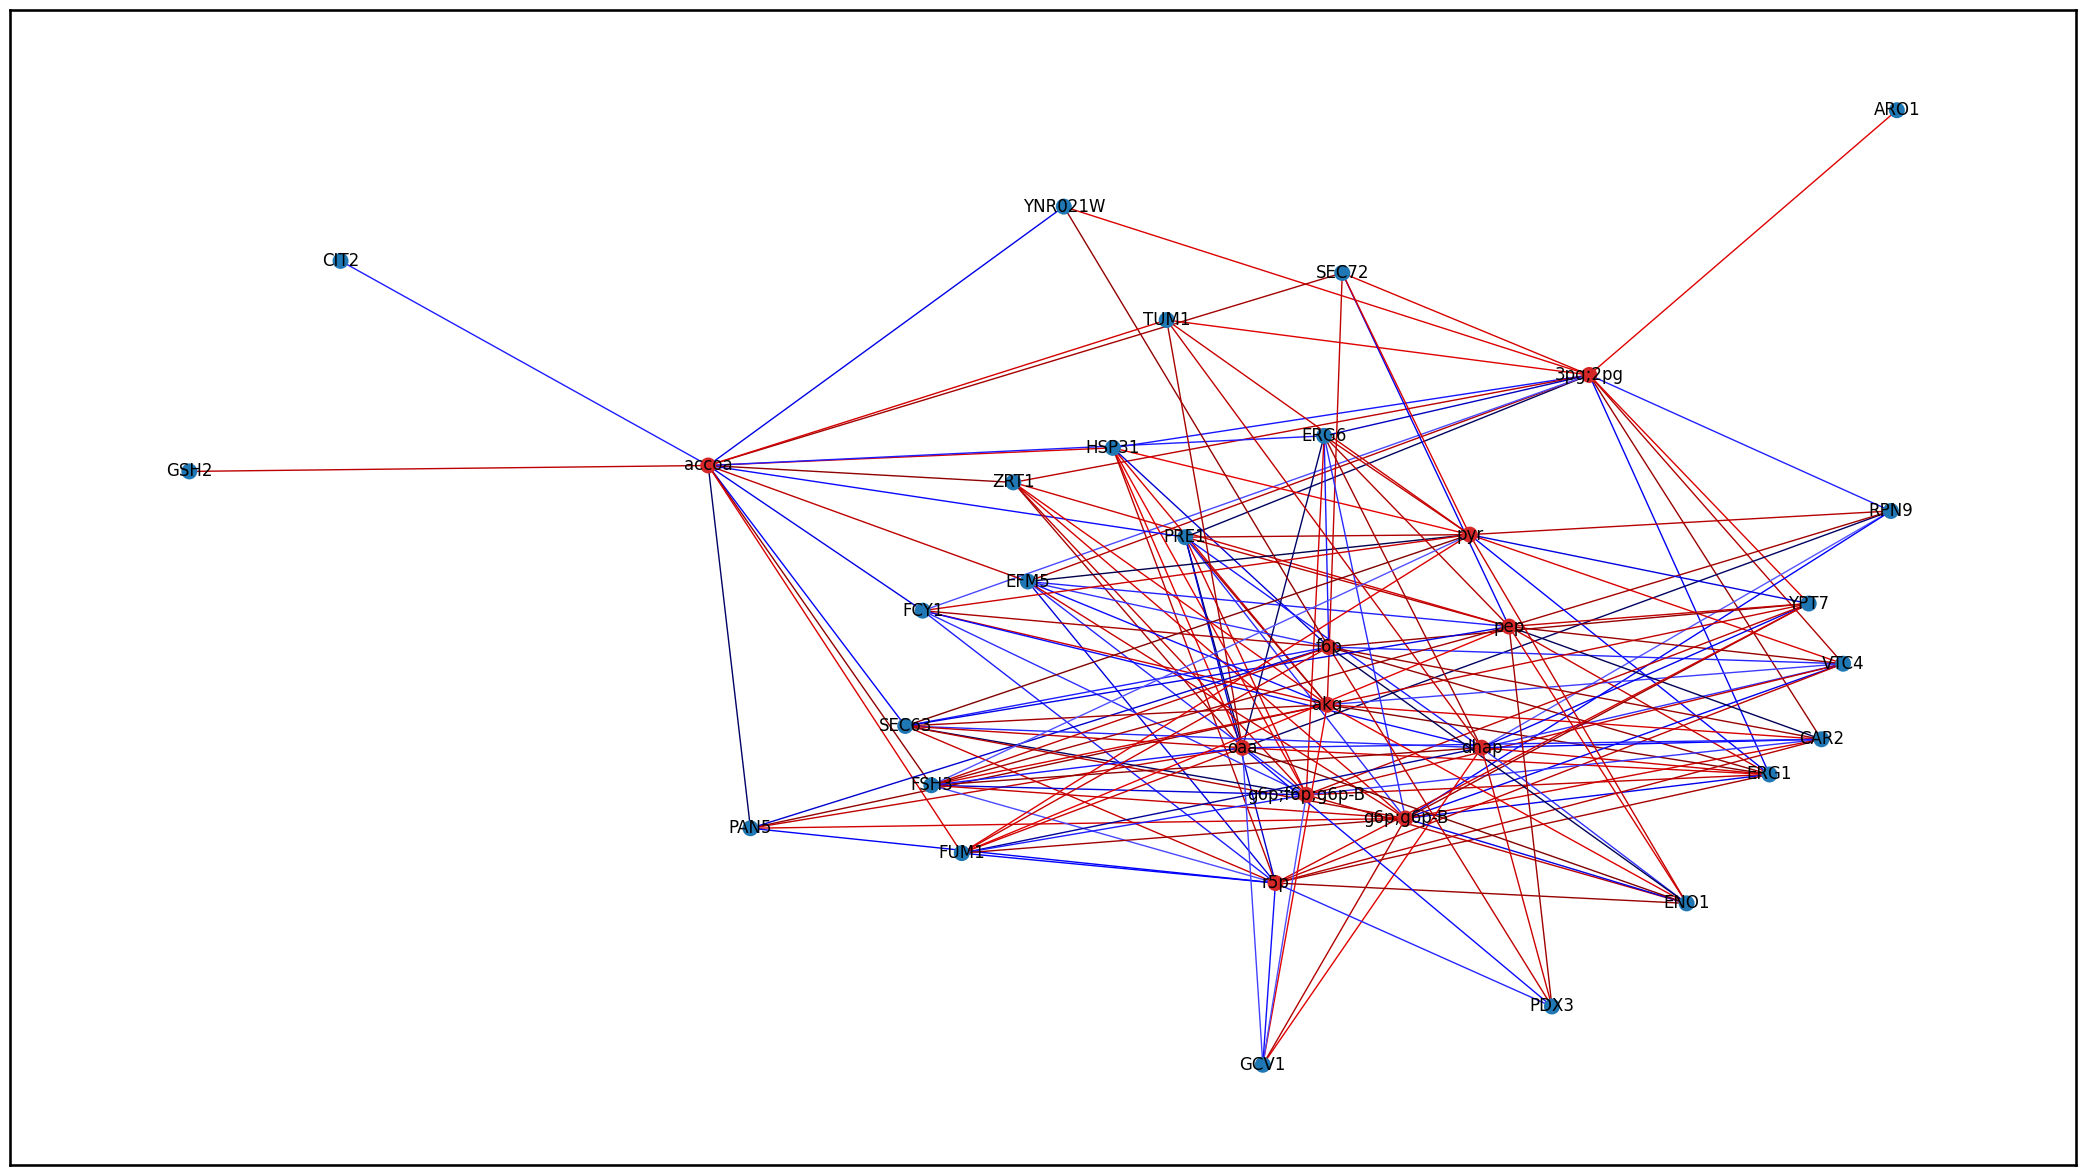

In [191]:
import networkx as nx

# fig = set_context(MODE)
fig = plt.figure(figsize=(FIGSIZE_TALK[0] * 2, FIGSIZE_TALK[1] * 2))
axgrid= fig.add_gridspec(6, 4)

NROWS, NCOLS = 6, 4
LOWER, MIDDLE, UPPER = int(NROWS / 3), int(2 * NROWS / 3), NROWS
LEFT, RIGHT = int(NCOLS / 2), NCOLS

ax0 = fig.add_subplot(axgrid[:, :])

df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.ALL)
df = df[['metabolite_id', 'exp_enzymes', 'exp_weights']].explode(column=['exp_enzymes', 'exp_weights'])
df = df.groupby(by=['metabolite_id']).head(15).groupby(by=['metabolite_id', 'exp_enzymes']).aggregate(['mean', 'count']).reset_index()

enzyme_nodes = df['exp_enzymes'].unique()
metabolite_nodes = df['metabolite_id'].unique()

lime_explaination_graph = nx.from_pandas_edgelist(df, source='exp_enzymes', target='metabolite_id')
protein_info = pd.read_json("/home/tvangraft/tudelft/thesis/metaengineering/data/training/gene_annotation.json").T.explode('gene_prefered_name').reset_index(names=['orf'])
orf_to_human = protein_info[['orf', 'gene_prefered_name']].set_index('orf').to_dict()['gene_prefered_name']

lime_explaination_graph = nx.relabel_nodes(lime_explaination_graph, orf_to_human)
# pos = nx.nx_agraph.graphviz_layout(lime_explaination_graph)
pos = nx.kamada_kawai_layout(lime_explaination_graph)
pos = nx.rescale_layout_dict(pos, .1)
color_map = ["tab:blue" if node not in metabolite_nodes else "tab:red" for node in lime_explaination_graph]



nx.draw_networkx(
    lime_explaination_graph,
    pos = pos,
    node_size=100,
    ax=ax0,
    node_color=color_map,
    edge_cmap=plt.cm.seismic,
    edge_color=df[('exp_weights', 'mean')].values
)

# from pyvis.network import Network
# net = Network()
# net.from_nx(lime_explaination_graph)
# net.show("example.html")

In [192]:
from src.utils.stoichiometry_to_graph import get_gene_reaction, is_precursor_metabolite, get_matching_precursor_metabolite, get_edge_list, build_graph_directional
from cobra.util import create_stoichiometric_matrix
import cobra
from src.pipeline.dataloader import DataLoader
from more_itertools import flatten

path = "/home/tvangraft/tudelft/thesis/metaengineering/data"
metabolic_model = cobra.io.read_sbml_model(f'{path}/iMM904.xml')
with open('cobra_metabolites', 'w') as f:
    f.write('\n'.join(create_stoichiometric_matrix(metabolic_model, array_type="DataFrame").index.to_list()))

with open('./data/iMM904.json', 'w') as f:
    f.write(cobra.io.to_json(metabolic_model))


DataLoader.DATA_FOLDER = './data/training/'
dl = DataLoader()
protein_metabolite_df = dl.get_simple_protein_metabolite_dataframe()

ENZYMES = protein_metabolite_df.to_df().columns.to_list()
lime_explaination_graph = nx.from_pandas_edgelist(df, source='exp_enzymes', target='metabolite_id')
protein_info = pd.read_json("/home/tvangraft/tudelft/thesis/metaengineering/data/training/gene_annotation.json").T.explode('gene_prefered_name').reset_index(names=['orf'])
orf_to_human = protein_info[['orf', 'gene_prefered_name']].set_index('orf').to_dict()['gene_prefered_name']

METABOLITES = protein_metabolite_df.obs.columns.to_list()
METABOLITES = [metabolite.replace('-', '__') for metabolite in METABOLITES]
METABOLITES = list(flatten(map(lambda x: str.split(x, ';'), METABOLITES)))

gene_to_reaction, reaction_to_gene = get_gene_reaction(metabolic_model, ENZYMES)
reaction_to_enzyme = pd.MultiIndex.from_tuples(
    [(reaction_id, enzyme_id) for reaction_id, enzymes in reaction_to_gene.items() for enzyme_id in enzymes],
    names=['reaction_id', 'enzyme_id']
)

edge_list_df = get_edge_list(metabolic_model, valid_metabolites=METABOLITES, valid_enzymes=ENZYMES)
metabolite_to_enzyme = pd.MultiIndex.from_frame(
    edge_list_df[['metabolite_id', 'enzyme', 'cardinality']],
    names=['metabolite_id', 'enzyme_id', 'cardinality']
)

reaction_metabolite_enzyme: pd.MultiIndex = metabolite_to_enzyme.join(reaction_to_enzyme)
reaction_metabolite_enzyme = reaction_metabolite_enzyme.reorder_levels(['enzyme_id', 'reaction_id', 'metabolite_id', 'cardinality'])

G_raw = build_graph_directional(reaction_metabolite_enzyme)

explanation_df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.ALL)
explanation_df = explanation_df[['metabolite_id', 'exp_enzymes', 'exp_weights']].explode(column=['exp_enzymes', 'exp_weights'])
explanation_df = explanation_df.groupby(by=['metabolite_id']).head(50).groupby(by=['metabolite_id', 'exp_enzymes']).aggregate(['mean', 'count']).reset_index()
explanation_df

ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


metabolite_id exp_enzymes exp_weights      
                                     mean count
0         3pg;2pg     YBR079C   -0.014565     1
1         3pg;2pg     YBR154C   -0.010954     1
2         3pg;2pg     YBR249C    0.013618     1
3         3pg;2pg     YDL143W   -0.014948     1
4         3pg;2pg     YDL182W   -0.013052     1
..            ...         ...         ...   ...
545           r5p     YOR280C   -0.020574     1
546           r5p     YOR323C   -0.013126     1
547           r5p     YOR374W    0.011803     1
548           r5p     YPL262W    0.025742     1
549           r5p     YPR062W   -0.018660     1

[550 rows x 4 columns]

In [193]:
all_paths = []
metabolite_id = 'pyr'
for target_enzyme in explanation_df[explanation_df['metabolite_id'] == metabolite_id].loc[:, 'exp_enzymes'].values:
    if target_enzyme in G_raw:
        if nx.has_path(G_raw, source=metabolite_id, target=target_enzyme):
            paths = list(nx.all_shortest_paths(G_raw, source=metabolite_id, target=target_enzyme))
            for path in paths:
                print(path)
                all_paths.append(path)
        elif nx.has_path(G_raw, target=metabolite_id, source=target_enzyme):
            paths = list(nx.all_shortest_paths(G_raw, target=metabolite_id, source=target_enzyme))
            for path in paths:
                print(path)
                all_paths.append(path)

['YBR249C', 'DDPA', 'e4p', 'FBA3', 'fdp', 'PFK', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA', 'fdp', 'PFK', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA2', 'fdp', 'PFK', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA3', 'fdp', 'PFK_2', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA', 'fdp', 'PFK_2', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA2', 'fdp', 'PFK_2', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA3', 'fdp', 'PFK_3', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA', 'fdp', 'PFK_3', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA2', 'fdp', 'PFK_3', 'atp', 'PYK', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA3', 'fdp', 'PFK', 'atp', 'ATPS3m', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA', 'fdp', 'PFK', 'atp', 'ATPS3m', 'adp', 'PC', 'pyr']
['YBR249C', 'DDPA', 'e4p', 'FBA2', 'fdp', 'PFK', 'atp', 'ATPS3m', 'adp', 

{'ENO', 'ANS', 'YKL060C', 'HSTPT', 'ATPS3m', 'DHQTi', 'YMR108W', 'gln__L', 'GLUDy', 'FBA', 'YOL058W', 'ME1m', 'FBA3', 'FAS120COA', 'YHR018C', 'ACCOAC', 'PFK', 'YCR005C', 'FAS180', 'FAS100', 'YML126C', 'TRPTA', 'ACLSm', 'FUMm', 'FAS120', 'pyr', 'FAS180COA', 'HMGCOAS', 'TYRTAi', 'YBR249C', 'pep', 'mal__L', 'fum', 'SHKK', 'YGR254W', 'NTRLASE2', 'YLR351C', 'YPL262W', 'YDR127W', 'e4p', 'FAS80COA_L', 'YLR354C', 'DHQS', 'FAS100COA', 'ACOTAim', 'ADK1', 'FAS140COA', 'glu__L', 'ATPS3v', 'PYK', 'HCITSn', 'YDL182W', 'FAS160COA', 'ATPS3g', 'CSp', 'ADK3', 'SHK3Dr', 'ARGSS', 'FAS140', 'ADK4', 'GTHS', 'PSCVT', 'YHR174W', 'FBA2', 'PC', 'ME2m', 'FAS160', 'akg', 'f6p', 'cit', 'ICDHxm', 'ACHBSm', 'NTRLASE3', 'FAS80_L', 'PFK_2', 'DDPA', 'HMGCOASm', 'gly', 'ICDHym', 'YOL049W', 'ARGSL', 'PFK_3', 'OHPBAT', 'PSERT', 'fdp', 'NTRLASE', 'GLNS', 'TALA', 'PHETA1', 'accoa', 'FUM'}


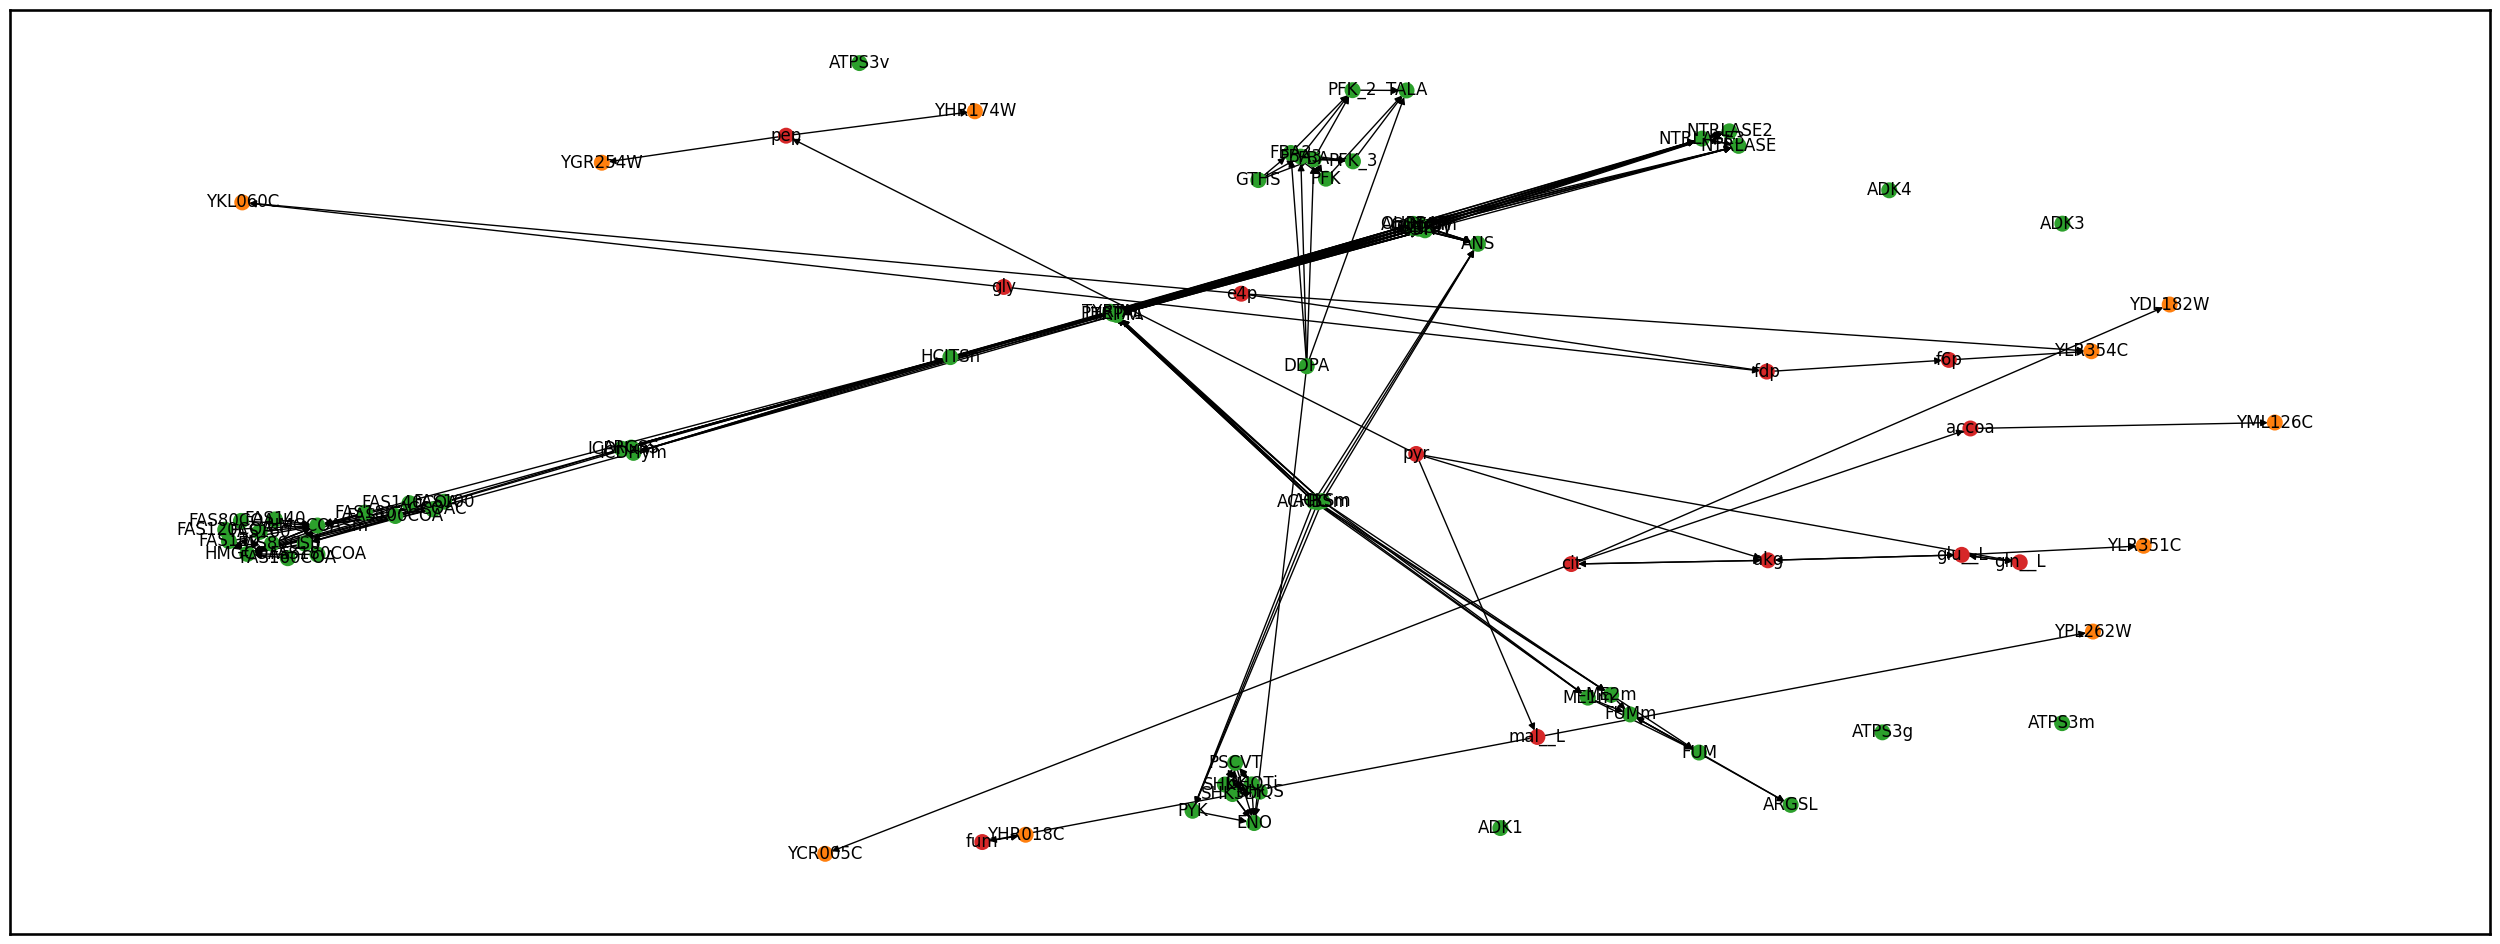

In [194]:
ENZYME_COLOR = "tab:blue"
METABOLITE_COLOR = "tab:red"
REACTION_COLOR = "tab:green"
def get_color(G, node):
    if 'layer' not in G.nodes[node]:
        return "tab:orange"


    layer = G.nodes[node]['layer']
    if layer == 2:
        return METABOLITE_COLOR   
    elif layer == 1:
        return REACTION_COLOR
    elif layer == 0:
        return ENZYME_COLOR

def get_enzymes_from_path(path):
    enzyme_ids = []
    _t = reaction_metabolite_enzyme.to_frame()
    for node in path:
        enzyme_ids.extend(_t[_t['reaction_id'] == node]['enzyme_id'].values.tolist())
    return enzyme_ids

def filter_explanation_enzymes(nodes, valid_enzymes):
    return [node for node in nodes if node in valid_enzymes]

valid_enzymes = explanation_df[(explanation_df['metabolite_id'] == metabolite_id)]['exp_enzymes'].values.tolist()

nodes = []
for path in all_paths:
    nodes = nodes + path + filter_explanation_enzymes(get_enzymes_from_path(path), valid_enzymes)

nodes = set(nodes)

nodes.remove('atp')
nodes.remove('adp')
nodes.remove('amp')

print(nodes)

G_prime = G_raw.subgraph(nodes)

G_prime = nx.algorithms.bipartite.projected_graph(
    G_prime, 
    [x for x,y in G_prime.nodes(data=True) if y['layer'] == 2 or y['layer'] == 1]
)


pos = nx.spring_layout(G_prime)
fig, ax0 = plt.subplots(1, 1, figsize=(32, 12))
nx.draw_networkx(
    G_prime,
    pos = pos,
    node_size=100,
    node_color=[get_color(G_prime, node) for node in G_prime],
    with_labels=True,
    ax=ax0,
)

In [195]:
gene_to_reaction['YCR005C']

['CSp']

# Shap analysis

In [196]:
from shap import KernelExplainer, kmeans, Explanation
from shap.plots import beeswarm, decision, waterfall
import shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


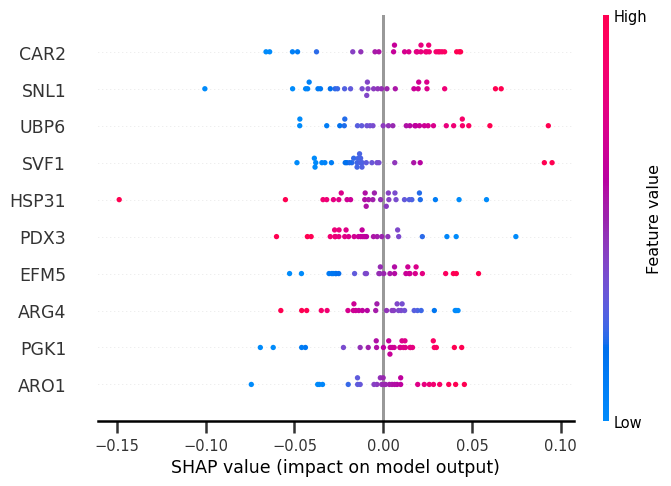

In [197]:
fig = set_context(MODE)
ax0 = fig.add_subplot(1, 1, 1)

metabolite_id = 'pyr'
strategy = Strategy.METABOLITE_CENTRIC
tier = Tier.TIER0
shap_explanations = get_shap_df(tier=tier, strategy=strategy)
model = load_model(tier=tier, strategy=strategy, metabolite=metabolite_id)

selected_feature_names = [x.replace('num__', '') for x in model.regressor_[:-1].get_feature_names_out()]
protein_info = pd.read_json("/home/tvangraft/tudelft/thesis/metaengineering/data/training/gene_annotation.json").T.explode('gene_prefered_name').reset_index(names=['orf'])
explanation = Explanation(shap_explanations[metabolite_id], feature_names=protein_info[protein_info['orf'] == selected_feature_names]['gene_prefered_name'].values.tolist())
explanation[:, :20]

vals = np.abs(explanation.values).mean(0)
order = np.argsort((-vals))
beeswarm(explanation[:, order][:, :10], max_display=10, show=False)
save_fig(path=f'./images/{MODE}/explanation/', name="pyruvate_single_metabolite_tier_0_explanation")

In [198]:
explanation_df_lime = get_lime_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)
explanation_df_shap = get_shap_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)

In [199]:
shap.initjs()
explanation = Explanation(explanation_df_shap['pyr'])
shap.force_plot(explanation[0])

In [200]:
explanation_df_lime[explanation_df_lime['metabolite_id'] == 'pyr']

,KO_ORF,metabolite_id,exp_enzymes,exp_weights,y_true,y_pred
0,YMR104C,pyr,"[YLR438W, YML008C, YDR346C, YBR035C, YHR018C, ...","[0.036584460900000004, -0.0359391311, 0.035573...",0.789449,1.096708
1,YBR097W,pyr,"[YDR346C, YFR010W, YLR438W, YDR127W, YCR012W, ...","[0.036629397200000004, 0.0361980533, 0.0336464...",-0.285636,-0.422620
2,YOL016C,pyr,"[YDR346C, YML008C, YFR010W, YLR438W, YHR018C, ...","[0.0375615892, -0.036975357800000004, 0.036162...",0.851337,0.829986
3,YPL026C,pyr,"[YLR438W, YDR346C, YML008C, YFR010W, YHR018C, ...","[0.0358106131, 0.0357531581, -0.0346396995, 0....",0.712332,0.703221
4,YFR014C,pyr,"[YLR438W, YDR346C, YFR010W, YML008C, YHR018C, ...","[0.0381285984, 0.0379276595, 0.037425499800000...",0.788056,0.776363
5,YOR351C,pyr,"[YDR346C, YML008C, YFR010W, YLR438W, YDR533C, ...","[0.0388718147, -0.0372799126, 0.03560221480000...",0.416186,0.258904
6,YBL016W,pyr,"[YFR010W, YML008C, YHR018C, YDR127W, YDR533C, ...","[0.036307181800000005, -0.0338365448, -0.03268...",1.128152,0.526106
7,YMR216C,pyr,"[YDR346C, YLR438W, YFR010W, YML008C, YHR018C, ...","[0.0384140294, 0.0362528134, 0.0360474581, -0....",0.412044,0.722988
8,YJL165C,pyr,"[YFR010W, YDR346C, YML008C, YLR438W, YHR018C, ...","[0.0378708798, 0.0372157001, -0.03656819180000...",0.974453,1.092846
9,YLR362W,pyr,"[YFR010W, YDR346C, YLR438W, YML008C, YDR127W, ...","[0.036981293900000003, 0.0367782586, 0.0365910...",0.922365,0.896245


In [201]:
explanation_df_lime[explanation_df_lime['metabolite_id'] == 'pep']['y_true'].mean()

0.5001480298172415

In [202]:
explanation.base_values

array([0.50187876, 0.50187876, 0.50187876, 0.50187876, 0.50187876,
       0.50187876, 0.50187876, 0.50187876, 0.50187876, 0.50187876,
       0.50187876, 0.50187876, 0.50187876, 0.50187876, 0.50187876,
       0.50187876, 0.50187876, 0.50187876, 0.50187876, 0.50187876,
       0.50187876, 0.50187876, 0.50187876, 0.50187876, 0.50187876,
       0.50187876, 0.50187876, 0.50187876, 0.50187876])

In [203]:
explanation_df_shap.keys()

dict_keys(['pep', 'dhap', 'pyr'])

In [204]:
explanation = Explanation(explanation_df_shap['pep'])
explanation.values.sum(axis=1) + explanation.base_values

array([ 0.26126426,  0.52656032,  0.71964977,  0.7812134 ,  0.3250217 ,
        0.5267695 ,  0.1827931 ,  0.7219999 ,  0.97943436,  0.78790447,
        0.76323049, -1.00501347,  0.88727338,  0.7988806 ,  0.90323828,
        1.00159131,  0.45109507,  0.72832042,  0.85767736,  0.50677919,
        0.50379644,  0.58942741, -0.66752992, -0.5975108 ,  0.82389519,
        0.15001364,  0.32338343,  0.90542189,  0.76771216])

# Explanation evaluation

In [446]:
from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader
from src.pipeline.dataloader import DataLoader
from src.pipeline.trainer import Trainer

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, LeavePOut, KFold
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

In [295]:
metabolite_id = 'pep'
strategy = Strategy.METABOLITE_CENTRIC
tier = Tier.TIER0
model = load_model(tier=tier, strategy=strategy, metabolite=metabolite_id)
model

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('scaler',
                                                                                                        MinMaxScaler())]),
                                                                                       ['YAL003W',
                                                                                        'YAL005C',
                                                                                        'YAL007C',
                                                                                        'YAL012W',
                                                                                        'YAL035W',
                                                                                        'YAL038W',
                                                                                        'YAL042W',
                                                                                        'YAL044C',
                                                                                        'YAR002C-A',
                                                                                        'YAR007C',
                                                                                        'YAR015W',
                                                                                        'YBL015W',
                                                                                        'YBL024W',
                                                                                        'YBL026W',
                                                                                        'YBL030C',
                                                                                        'YBL039C',
                                                                                        'YBL041W',
                                                                                        'YBL045C',
                                                                                        'YBL050W',
                                                                                        'YBL058W',
                                                                                        'YBL064C',
                                                                                        'YBL076C',
                                                                                        'YBL091C',
                                                                                        'YBL092W',
                                                                                        'YBL099W',
                                                                                        'YBR011C',
                                                                                        'YBR025C',
                                                                                        'YBR026C',
                                                                                        'YBR031W',
                                                                                        'YBR035C', ...])])),
                                                     ('regressor',
                                                      SVR(C=100.0,
                                                          kernel='sigmoid'))]))

In [350]:
metabolite_id = '3pg;2pg'
strategy = Strategy.METABOLITE_CENTRIC
tier = Tier.TIER0
model = load_model(tier=tier, strategy=strategy, metabolite=metabolite_id)

model

DataLoader.DATA_FOLDER = f'{get_project_root()}/data/training/'
tier = Tier.TIER0

dl_config = DataLoaderConfig(
    additional_filters=['is_precursor'],
    additional_transforms=["log_fold_change_protein"]
)

dl = DataLoader()
dl.prepare_dataloader(dl_config)

tl = TaskLoader()
tl.prepare_taskloader(TaskLoaderConfig())

gen = get_generator(dl, tl, strategy, tier)

for tf in gen:
    if tf.frame_name == metabolite_id:
        break

print(tf.frame_name)
trainer = Trainer()
split_kwargs = dict(shuffle=False, stratify=None)

X_train, X_test, y_train, y_test = trainer.do_train_test_split(tf, **split_kwargs)

ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f9bd1fa5fd0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f9bd1fa5d00>>])
3pg;2pg


In [332]:
def apply_transform(_model, X):
    _X = X
    for step in _model.regressor_.steps[:-1]:
        _X = step[1].transform(_X)
    return _X

def apply_predict(_model, X):
    return _model.regressor_.named_steps['regressor'].predict(X)

In [335]:
y_pred = apply_predict(model, apply_transform(model, X_train))

def median_absolute_percentage_error(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    ape = np.abs(y_pred - y_true) / np.abs(y_true)
    return np.median(ape)

print(f"training mae: {mean_absolute_error(apply_predict(model, apply_transform(model, X_train)), y_train)}")
print(f"testing mae: {mean_absolute_error(apply_predict(model, apply_transform(model, X_test)), y_test)}")

training mae: 0.5475754470215561
testing mae: 0.40192655745667877


In [ ]:
-0.356690
-0.353193
-0.353181

In [458]:
ct = ColumnTransformer([
    ("num", MinMaxScaler(), X_train.columns[1:])
], remainder='drop')

pipeline = make_pipeline(
    ct,
    RandomForestRegressor()
)

scorer = make_scorer(
    median_absolute_percentage_error,
    greater_is_better=False
)

cv = GridSearchCV(
    pipeline,
    {
        'randomforestregressor__n_estimators': [10, 25, 50, 75, 100],
        'randomforestregressor__criterion': ['squared_error', 'friedman_mse'],
        'randomforestregressor__max_depth': [5, 10, 20],
    },
    scoring=scorer,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score='raise',
    # cv=LeavePOut(p=1),
    cv=KFold(n_splits=10),
)

cv.fit(X_train, y_train)
# pd.DataFrame(cv.cv_results_).sort_values(by='rank_test_score')

print(cv.predict(X_test))
print(f"training mae: {mean_absolute_error(cv.predict(X_train), y_train)}")
print(f"testing mae: {mean_absolute_error(cv.predict(X_test), y_test)}")
print(f"testing mdAPE: {median_absolute_percentage_error(y_test, cv.predict(X_test))}")

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[ 0.25562109  0.39047821  0.35584284  0.16045669  0.60827033  0.29194683
  0.4347072   0.59953753  0.38163762 -0.0790956  -0.37569821  0.51557712
  0.14644076  0.61785387  0.5509726   0.25073547  0.05869478 -0.19117286
  0.57055808  0.31789931  0.63643517  0.57892384  0.33043504  0.65420282
  0.68643743  0.57511583  0.61034466 -0.19589422 -0.1925381 ]
training mae: 0.14741155650970644
testing mae: 0.5158010886282848
testing mdAPE: 0.6410672727099854


In [462]:
ct = ColumnTransformer([
    ("num", MinMaxScaler(), X_train.columns[1:])
], remainder='drop')

pipeline = make_pipeline(
    ct,
    SVR()
)

scorer = make_scorer(
    mean_absolute_error,
    greater_is_better=False
)

cv = GridSearchCV(
    pipeline,
    {
        'svr__kernel': ['sigmoid', 'rbf'],
        'svr__gamma': ['auto', 'scale', 0.1, 0.001, 0.01],
        'svr__C': [10, 100, 1000],
        'svr__epsilon': [0.1, 0.01, 0.001, 0.0001],
    },
    scoring=scorer,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score='raise',
    # cv=LeavePOut(p=1),
    cv=KFold(n_splits=10),
)

cv.fit(X_train, y_train)
print(cv.predict(X_test))
print(f"training mae: {mean_absolute_error(cv.predict(X_train), y_train)}")
print(f"testing mae: {mean_absolute_error(cv.predict(X_test), y_test)}")
print(f"testing mdAPE: {median_absolute_percentage_error(y_test, cv.predict(X_test))}")

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[0.54070349 0.47250031 0.5352848  0.93241942 0.4777927  0.70014156
 0.59907275 0.63339869 0.5783911  0.39071243 0.27059916 0.67988704
 0.61935045 0.81362213 0.55184798 0.7941952  0.38913729 0.19212361
 0.58967143 0.74155042 0.66473116 0.53952388 0.46759149 0.49791443
 0.63694893 0.66429512 0.80002084 0.50954901 0.26710661]
training mae: 0.2446189475792219
testing mae: 0.45949611570511223
testing mdAPE: 0.2407661705445132


In [476]:
ct = ColumnTransformer([
    ("num", MinMaxScaler(), X_train.columns[1:])
], remainder='drop')

pipeline = make_pipeline(
    ct,
    MLPRegressor()
)

scorer = make_scorer(
    mean_absolute_error,
    greater_is_better=False
)

cv = GridSearchCV(
    pipeline,
    {
        'mlpregressor__hidden_layer_sizes': [[128, 32, 32], [64, 32]],
        'mlpregressor__batch_size': [8, 16, 4, 2],
        'mlpregressor__activation': ['relu'],
    },
    scoring=scorer,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score='raise',
    # cv=LeavePOut(p=1),
    cv=KFold(n_splits=10),
)

cv.fit(X_train, y_train)
print(cv.predict(X_test))
print(f"training mae: {mean_absolute_error(cv.predict(X_train), y_train)}")
print(f"testing mae: {mean_absolute_error(cv.predict(X_test), y_test)}")
print(f"testing mdAPE: {median_absolute_percentage_error(y_test, cv.predict(X_test))}")

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[-0.31552807  0.07976065  0.64831811  0.8153369   0.50644333  0.72403047
  0.52400112  0.70321473  0.3501677  -0.37757912 -0.80838147  0.68410299
  0.58469     0.80315449  0.49896125  0.72273267 -0.75654393 -1.21901466
  0.59485842  0.76067454  0.62455997  0.35639631 -0.02466455  0.62802369
  0.621683    0.52166432  0.73266071  0.4056429  -0.91020494]
training mae: 0.06919029299798177
testing mae: 0.49894823840113495
testing mdAPE: 0.27032400432510517


In [479]:
cv.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['YAL003W', 'YAL005C', 'YAL007C', 'YAL012W', 'YAL035W', 'YAL038W',
       'YAL042W', 'YAL044C', 'YAR002C-A', 'YAR007C',
       ...
       'YPR129W', 'YPR133C', 'YPR145W', 'YPR160W', 'YPR163C', 'YPR165W',
       'YPR181C', 'YPR183W', 'YPR187W', 'YPR191W'],
      dtype='object', length=726))])),
                ('mlpregressor',
                 MLPRegressor(batch_size=4, hidden_layer_sizes=[128, 32, 32]))])

In [ ]:
pipeline = cv.best_estimator_
pipeline_apply_predict = lambda _model: lambda X: _model.named_steps['mlpregressor'].predict(X)
def pipeline_apply_transform(X):
    _X = X
    for step in pipeline.steps[:-1]:
        _X = step[1].transform(_X)
    return _X

X_train_summary = shap.kmeans(pipeline_apply_transform(X_train), 4)
ex = shap.KernelExplainer(pipeline_apply_predict(pipeline), X_train_summary)
sv = ex.shap_values(pipeline_apply_transform(X_test), gc_collect=True)
exp = shap.Explanation(sv, np.array([ex.expected_value] * len(X_test)), data=pipeline_apply_transform(X_test), feature_names=selected_feature_names)

In [483]:
(y_train.mean() + y_test.mean()) / 2

0.34999572201412277

In [482]:
ex.expected_value

0.5019359844533908

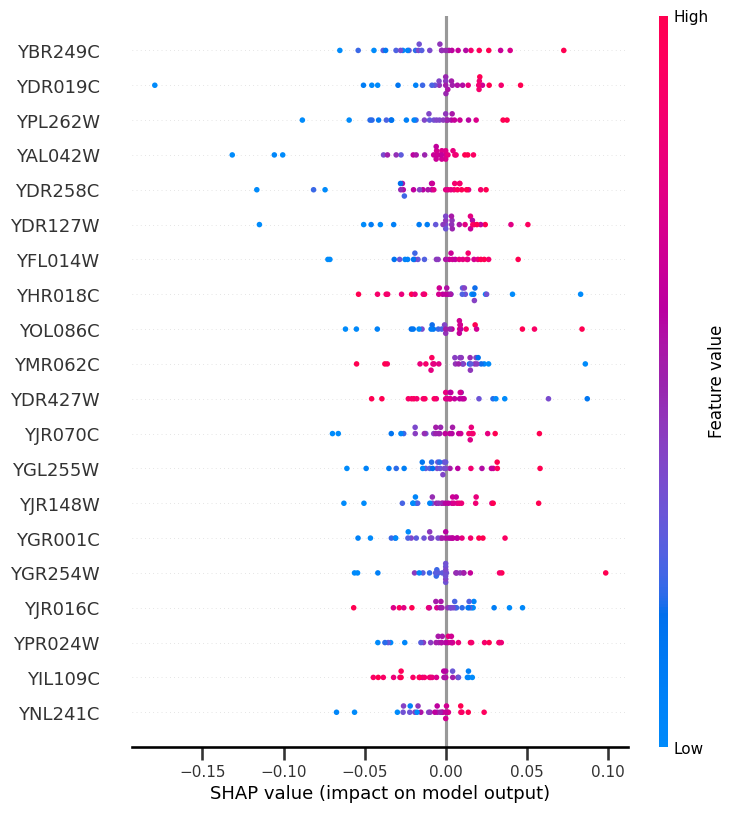

In [485]:
vals = np.abs(exp.values).mean(0)
order = np.argsort((-vals))
beeswarm(exp[:, order][:, :20], max_display=20, show=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


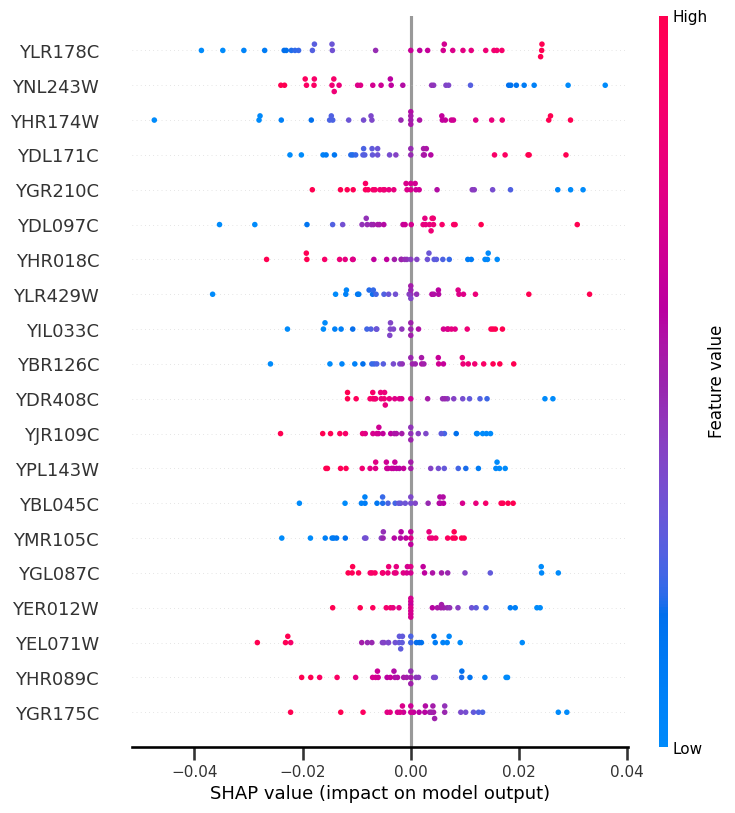

In [342]:
explanation = Explanation(shap_explanations[metabolite_id], feature_names=protein_info[protein_info['orf'] == selected_feature_names]['gene_prefered_name'].values.tolist())
vals = np.abs(exp.values).mean(0)
order = np.argsort((-vals))
beeswarm(exp[:, order][:, :20], max_display=20, show=False)